In [2]:
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




In [3]:
#Load and preprocess the dataset
data_dir = '/Users/anurag_singh/Desktop/Anurag/Learning/ML/ML_Workspace/machine-learning/Dataset/tom_and_jerry'
image_size = (224, 224)

In [4]:
#Load and label data from subfolders
data = []
labels = []

subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        data.append(os.path.join(subfolder, image_file))
        labels.append(label)

        
# Create a DataFrame from the data and labels
df = pd.DataFrame({'image_file': data, 'label': labels})

In [5]:
df

,image_file,label
0,jerry/frame4782.jpg,0
1,jerry/frame3947.jpg,0
2,jerry/frame5463.jpg,0
3,jerry/frame3012.jpg,0
4,jerry/frame1163.jpg,0
...,...,...
5473,tom_jerry_1/frame203.jpg,3
5474,tom_jerry_1/frame5446.jpg,3
5475,tom_jerry_1/frame3779.jpg,3
5476,tom_jerry_1/frame2315.jpg,3


In [6]:
#Split the dataset into training, validation, and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

      

In [7]:
# Define a neural network model
# Defining the base mode InceptionV3
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(len(subfolders), activation='softmax')(x)  # Number of output classes
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_model()

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=data_dir,
    x_col='image_file',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=data_dir,
    x_col='image_file',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Found 3943 validated image filenames.
Found 439 validated image filenames.
Epoch 1/10
124/124 [==============================] - 247s 2s/step - loss: 0.8379 - accuracy: 0.6736 - val_loss: 6.8308 - val_accuracy: 0.3941
Epoch 2/10
124/124 [==============================] - 243s 2s/step - loss: 0.4597 - accuracy: 0.8486 - val_loss: 1.7156 - val_accuracy: 0.7380
Epoch 3/10
124/124 [==============================] - 246s 2s/step - loss: 0.3411 - accuracy: 0.8920 - val_loss: 0.7645 - val_accuracy: 0.8633
Epoch 4/10
124/124 [==============================] - 244s 2s/step - loss: 0.3116 - accuracy: 0.8998 - val_loss: 3.1720 - val_accuracy: 0.5649
Epoch 5/10
124/124 [==============================] - 246s 2s/step - loss: 0.2804 - accuracy: 0.9135 - val_loss: 0.3410 - val_accuracy: 0.8952
Epoch 6/10
124/124 [==============================] - 254s 2s/step - loss: 0.2383 - accuracy: 0.9214 - val_loss: 0.2271 - val_accuracy: 0.9294
Epoch 7/10
124/124 [==============================] - 245s 2s/step 

In [10]:
#Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

14/14 [==============================] - 7s 506ms/step - loss: 0.2840 - accuracy: 0.8793
Validation loss: 0.28399190306663513, Validation accuracy: 0.8792710900306702


In [11]:
#Fine-tune the model if needed

#Unfreeze some layers from the pre-trained model

for layer in model.layers:
    layer.trainable = True

In [12]:
# Compile the model again to apply the changes
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Fine-tune the model on the training data
fine_tune_epochs = 10

history_fine_tune = model.fit(train_generator,
                             epochs=epochs + fine_tune_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=val_generator)

Epoch 10/20
124/124 [==============================] - 251s 2s/step - loss: 0.1076 - accuracy: 0.9675 - val_loss: 0.0851 - val_accuracy: 0.9795
Epoch 11/20
124/124 [==============================] - 245s 2s/step - loss: 0.0826 - accuracy: 0.9749 - val_loss: 0.0692 - val_accuracy: 0.9704
Epoch 12/20
124/124 [==============================] - 244s 2s/step - loss: 0.0742 - accuracy: 0.9784 - val_loss: 0.0519 - val_accuracy: 0.9909
Epoch 13/20
124/124 [==============================] - 239s 2s/step - loss: 0.0518 - accuracy: 0.9845 - val_loss: 0.0543 - val_accuracy: 0.9886
Epoch 14/20
124/124 [==============================] - 246s 2s/step - loss: 0.0458 - accuracy: 0.9868 - val_loss: 0.0476 - val_accuracy: 0.9863
Epoch 15/20
124/124 [==============================] - 245s 2s/step - loss: 0.0595 - accuracy: 0.9807 - val_loss: 0.0837 - val_accuracy: 0.9749
Epoch 16/20
124/124 [==============================] - 274s 2s/step - loss: 0.0457 - accuracy: 0.9850 - val_loss: 0.0492 - val_accuracy:

In [13]:
#Evaluate the fine-tuned model on the validation data
val_loss_fine_tune, val_accuracy_fine_tune = model.evaluate(val_generator)
print(f'Validation loss (fine-tuned): {val_loss_fine_tune}, Validation accuracy (fine-tuned): {val_accuracy_fine_tune}')


14/14 [==============================] - 8s 587ms/step - loss: 0.0600 - accuracy: 0.9818
Validation loss (fine-tuned): 0.05996469780802727, Validation accuracy (fine-tuned): 0.981776773929596


In [14]:
#Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=data_dir,
    x_col='image_file',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Found 1096 validated image filenames.
35/35 [==============================] - 21s 588ms/step - loss: 0.2028 - accuracy: 0.9526
Test loss: 0.2027781903743744, Test accuracy: 0.9525547623634338


1/1 [==============================] - 1s 721ms/step


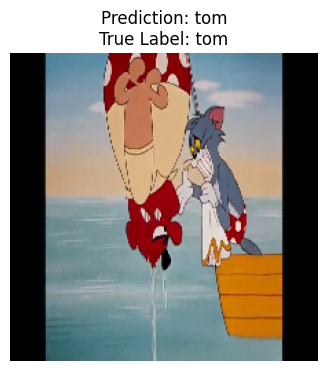

1/1 [==============================] - 0s 66ms/step


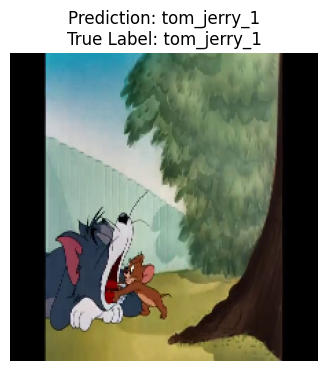

1/1 [==============================] - 0s 60ms/step


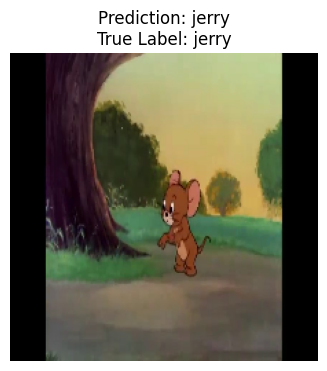

1/1 [==============================] - 0s 50ms/step


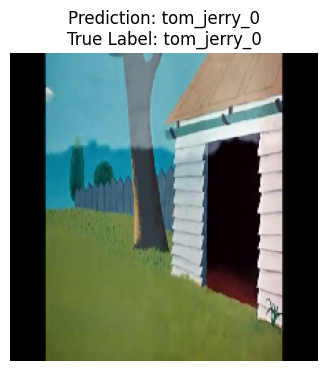

1/1 [==============================] - 0s 53ms/step


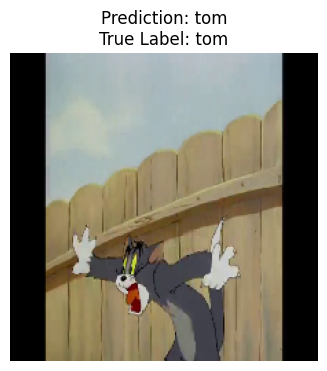

In [15]:
#Use case 1
#Detect the presence of characters 'tom' and 'jerry' in any given image

import matplotlib.pyplot as plt
import os

def display_image_predictions(df, data_dir, model):
    subset = df.sample(5, random_state=42)
    image_paths = subset['image_file'].apply(lambda x: os.path.join(data_dir, x)).tolist()
    true_labels = subset['label'].tolist()
    
    for i, image_path in enumerate(image_paths):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        prediction = model.predict(img_array)
        predicted_label = subfolders[np.argmax(prediction)]

        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        title = f"Prediction: {predicted_label}"
        if true_labels is not None:
            title += f"\nTrue Label: {subfolders[true_labels[i]]}"
        plt.title(title)
        plt.axis('off')
        plt.show()

# Assuming data_dir, df, and model are defined
display_image_predictions(df, data_dir, model)

In [16]:
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 95.26%
